<a href="https://colab.research.google.com/github/ferngonzalezp/deep_learning_lab/blob/main/session2/DL_labSession2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Convolutional Neural Networks

Convolutional neural networks or more commonly called by their abreviation "CNNs", is one of the most used architecure types of Neural Networks. These networks were inspired by the field of image processing, they use as building block the convolution operation instead of simple matrix multiplications. The use of convolutions have some advantages, such as:

* Reduced memory requirements: with convolutions the weights are filter or kernels that pass through the whole image, for example a 3x3 kernel has in total 9 weights and can be used in any image whose dimensions are equal or bigger than the ones from the kernel, if we used a linear layer the number of weights increase linearly with the number of pixels in the image.

* Convolutions are equivariant: this means that with convolutions we are able to identify features of an image regardless of their orientation. With a trained CNN for recognizing MNIST digits we can rotate the numbers or crop them and still be able to identify the number, this would be a hard task for linear layers.

## What is a Convolution extacly?

A convolution is the process of adding each element of the image to its local neighbors, weighted by the kernel. 

<img src='https://miro.medium.com/max/2400/1*VVvdh-BUKFh2pwDD0kPeRA@2x.gif'
width=500 height=300>

Convolutions also have certain parameters that control how they behave and the shape of their output:

* **Stride**:  specifies how much we move the convolution filter at each step.

Convolution with stride of 1: \\
<img src='https://miro.medium.com/max/2400/1*L4T6IXRalWoseBncjRr4wQ@2x.gif'
width=500 height=300> \\
Convolution with stride of 2: \\
<img src='https://miro.medium.com/max/2400/1*4wZt9G7W7CchZO-5rVxl5g@2x.gif'
width=500 height=300> \\

* **Padding**: these are extra values added arround the input image in order to achieve a desirable size of the reuslting operation. Normally the padding values are zeroes but others can be used like the values at the opposite edge.\\

<img src='https://miro.medium.com/max/2400/1*W2D564Gkad9lj3_6t9I2PA@2x.gif'
width=500 height=300> \\

* **Dilation**: The dilations is the ammount of gap between the kernle weights, it can be seen as expanding the kernel to a bigger one and filling the gaps with zeroes. The default value of dilation is 1. \\

<img src='https://www.researchgate.net/publication/320195101/figure/fig2/AS:669211164692494@1536563783748/Dilated-convolution-On-the-left-we-have-the-dilated-convolution-with-dilation-rate-r.png' width=600 height=300>\\

The dimension of the output of a convolution can be calculated as:

\begin{equation}
D_{o u t}=\left\lfloor\frac{D_{i n}+2 \times \text { padding }-\text { dilation } \times(\text { kernel_size }-1)-1}{\text { stride }}+1 \right\rfloor
\end{equation}



## Convolutional Neural Network for MNIST digits classification

Now we will try to solve the MNIST digit classification problem but using convolutions, we hope that by doing this we can increase accuracy.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision
import numpy as np
import matplotlib.pyplot as plt

If the dataset download doesn't work you can download the dataset from [here](http://yann.lecun.com/exdb/mnist/). Then save the .gz fikles under ./MNIST/raw/

In [ ]:
!git clone https://github.com/ferngonzalezp/MNIST

In [ ]:
transform = torchvision.transforms.ToTensor
train_dataset = datasets.MNIST(root='./',download=True, train=True, transform=transform())
test_dataset = datasets.MNIST(root='./', train=False, transform=transform())

In [ ]:
example = train_dataset[np.random.randint(0,len(train_dataset))]
plt.imshow(example[0][0], cmap='gray')
plt.title(example[1])

We will build a simple convolutional neural network for this task. The idea behind this CNN is to have some feature extraction layers using convolutions and then a fully connected output layer to compute the prediction of the labels.

<img src='https://drive.google.com/uc?id=1x989PyIOJSE3gCUaM2DmmOMKYLnsvx9w' width=800 height=400> \\

To reduce the dimensionality of the image we use a pooling operation.  This enables us to reduce the number of parameters, which both shortens the training time and combats overfitting. Pooling layers downsample each feature map independently, reducing the height and width, keeping the depth intact.

The most common type of pooling is max pooling which just takes the max value in the pooling window. Contrary to the convolution operation, pooling has no parameters. It slides a window over its input, and simply takes the max value in the window. Similar to a convolution, we specify the window size and stride.

Here is the result of max pooling using a 2x2 window and stride 2. Each color denotes a different window. Since both the window size and stride are 2, the windows are not overlapping. \\

<img src='https://miro.medium.com/max/2400/1*ReZNSf_Yr7Q1nqegGirsMQ@2x.png' widht=600 height=300> \\

The activation we use between convolutions is the rectified Linear unit (ReLU) and softmax in the output. We build our CNN pytorch module as follows: \\

In [ ]:
class cnn(nn.Module):
  def __init__(self):
    super(cnn,self).__init__()
    self.feature_extraction = nn.Sequential(
        nn.Conv2d(1,16,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.fc = nn.Sequential(
        nn.Linear(32*7*7,10),
        nn.Softmax(dim=1)
    )
  def forward(self,x):
    x = self.feature_extraction(x)
    x = torch.flatten(x,1)
    return self.fc(x)

Now the remaining part of the code remains the same just as in classification with MLP.
____

In [ ]:
#Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = cnn().to(device)

In [ ]:
print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print("number of parameters in model: %d"%(pytorch_total_params))

In [ ]:
#Hyperparameters
batch_size = 100
n_epochs = 10
learn_rate = 2e-1

In [ ]:
#DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
#Loss function and Optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=learn_rate)

In [ ]:
#Training Loop
train_loss = []
val_loss = []
for epoch in range(n_epochs):  # loop over the dataset multiple times
    epoch_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = F.one_hot(labels,10).type_as(inputs)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print statistics
        running_loss += loss.item()

        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
    train_loss.append(epoch_loss/(i+1))
    #Evaluation of the trained model
    correct = 0
    total = 0
    epoch_loss = 0.0
    print("validating...")
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            predicted = torch.argmax(outputs,dim=1)
            loss = criterion(outputs, F.one_hot(labels,10).type_as(inputs))
            labels =  labels.type_as(inputs)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()
            epoch_loss += loss.item()
    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))
    val_loss.append(epoch_loss/(i+1))

print('Finished Training')

In [ ]:
plt.plot(train_loss, label='training')
plt.plot(val_loss, label='validation')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

We can observe thet we achieve a higher accuracy with a CNN and with less training, even after the first epoch we got the same accuracy of the treined MLP.

In [ ]:
#Evaluation of the trained model
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels =  labels.type_as(inputs)
        outputs = model(inputs)
        predicted = torch.argmax(outputs,dim=1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 98 %


Let's plot some image to see how the model performs.

In [ ]:
from math import ceil
n_samples = 6
id = np.random.randint(0,len(test_dataset),n_samples)
rows = ceil(n_samples/3)
plt.figure(figsize=(rows*5,10))
for i in range(len(id)):
  images = test_dataset[id[i]][0].to(device)
  pred_labels = torch.argmax(model(images.unsqueeze(0)),dim=1)[0]
  plt.subplot(rows,3,i+1)
  plt.imshow(images[0].cpu(), cmap='gray')
  plt.title('prediction: %d'%(pred_labels))

# Tricks that help with performance, convergence and generalization

Using convolutional layers helps a lot in the performance of commputer vision, however for real wolrs applications and more difficult tasks it may not be enough. For that reason there exists a bag of tricks that drive CNNs towards greater accuracy, generalization and capacity for handling more complicated tasks. Here we will talk about some of the most used that are present nowadays in most of deep learning models.

## Batch Normalization

Batch normalization is used to fix the variance of the input of an activation function. This helps in reducuing the internal covariance shift in a neural networks as well as more practical benefits such as reducing the probability of having vanishing or exploding gradients and reducing generalization error. What BatchNorm does is first it calculates the mean and variance of the current mini-batch:

\begin{equation}
\mu_{B}=\frac{1}{m} \sum_{i=1}^{m} x_{i} \text { , and } \sigma_{B}^{2}=\frac{1}{m} \sum_{i=1}^{m}\left(x_{i}-\mu_{B}\right)^{2}
\end{equation}

Then normalizes the input of the layer as:

\begin{equation}
\hat{x}_{i}^{(k)}=\frac{x_{i}^{(k)}-\mu_{B}^{(k)}}{\sqrt{\sigma_{B}^{(k)^{2}}+\epsilon}}
\end{equation}

Where $k \in[1, d] \text { is the dimension number and } i \in[1, m] \text{ is the ith layer of the network}; \mu_{B}^{(k)} \text { and } \sigma_{B}^{(k)} \text{ are the per dimension mean and variance}$

$\epsilon$ is added in the denominator for numerical stability and is an arbitrarily small constant. The resulting normalized activation $\hat{x}_{i}^{(k)}$ have zero mean and unit variance if $\epsilon$ is not taken into account. To restore the representation power of the network, a transformation step then follows as:

\begin{equation}
y_{i}^{(k)}=\gamma^{(k)} \hat{x}_{i}^{(k)}+\beta^{(k)}
\end{equation}

Where $\gamma$ and $\beta$ are learnable parameters. Implementing BatchNorm is very straightforward in pytorch. In [pytorch](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d) we have the module **BatchNorm1d, BatchNorm2d, BatchNorm3d** depending in the dimensionality of our input, we need also to specify the number of features.  In a module we can use batchNorm like this:


```
self.feature_extraction = nn.Sequential(
        nn.Conv2d(1,16,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
```





## Momentum and other optimizers

Stochastic gradient descent is the basis of a family of gradient-based algorithms used for deep learning. As we have seen, SGD is not perfetc and there are ways to boost its performance. One of the most fundamental techniques used to better the convergence of SGD is momentum.  The most intuitive way to understand momentum is making an anlogy with the physical world, imagine we have a sphere that goes with a initial speed, if the sphere encounters an uphill it may get stucked because its momentum is not enough for conquering gravity. We can overcome this problem if we add a bigger slope before hill so we can reach our goal at the end.

<img src="https://drive.google.com/uc?id=1x7Rq43khSRRH9heFsxitjXfxBLaNdDTa" width=600 height=300>

In gradient descent, momentum adapts the learning rate in order to accelerate convergence.

<img src="https://drive.google.com/uc?id=1VGj-lN9Q3eL88XDxu1KaW1C7gXj3pggi" width=600 height=300>

In stochastic gradient descent with momentum, information of the previous updating step is used to update the current one:

\begin{equation}
\begin{array}{l}
v_{t+1}=\mu * v_{t}+g_{t+1} \\
p_{t+1}=p_{t}-\operatorname{lr} * v_{t+1}
\end{array}
\end{equation}

Where $p, g, v \text{ and } \mu$ denote the parameters, gradient, velocity and momentum respectively. In this case momentum is an hyperparameter where its value we can set, if it is 0 then we have normal SGD.

As said earlier there are many algorithms that can be used for opimizing a Neural Network, In the pytorch [documentation](https://pytorch.org/docs/stable/optim.html#algorithms) you can find more information about them and see what is available for you to solve your problem.

## Data augmentations

Generally the data we have may not be enough to achieve generalization, for example we may train a model to recognize images but it may fail is the image is corrupted with noise or is rotated, on the contrary of human perception where we still may recognize the content of an image even if it is disorted.

One way to overcome this and achieve greater performance is by performing transformations to the model during training. We may do these transofrmations randomly during the training loop, and by doing this we virtually increase the samples the model see during training, this is why it is called data augmentation.

In [ ]:
transforms = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(60),
            torchvision.transforms.ToTensor(),
]
)

In [ ]:
train_dataset = datasets.MNIST(root='./',download=True, train=True, transform=transforms)

Text(0.5, 1.0, '8')

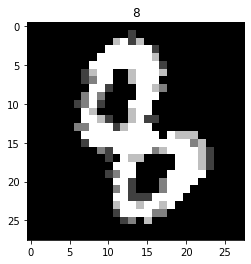

In [ ]:
example = train_dataset[np.random.randint(0,len(train_dataset))]
plt.imshow(example[0][0], cmap='gray')
plt.title(example[1])

# Build a classificator for the Fashion MNIST dataset

Now we will build a classificator for the fashion MNIST dataset. In the words of the author:

"Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits."

to download the dataset you can clone github repo with the command:
```
!git clone git@github.com:zalandoresearch/fashion-mnist.git
```

Or you can use the function in [torchvision](https://pytorch.org/vision/stable/datasets.html#fashion-mnist).

This practice will be free, and use of the documentation, working in groups and asking the instructor is encouraged. At the end you should build and test your model which needs to be reproductible in another computer. This problem have the following requirements:

1.   You should build two models: One an MLP and the other a CNN.
2.   You should use both models on MNIST and Fashion-MNIST.
3.   In the MLP model, keeping all the parameters the same, study the effect of increasing the number of layers of the network, use 2, 4 and 8 hidden layers. Make a graph of the accuray respect to the number of layers for both MNIST and Fashion-MNIST.
4.   Your can use batchNorm, dropout or any other techique that helps
 the number of layers and parameters of convolutions is free too.
5.   Use both SGD and SGD with momentum optimizer in the MLP an CNN, make a graph comparing the training loss curve with both optimizers for both datasets.
6.   Feel free to work in groups, search the web and ask questions but reporting remains individual.
7.   The metric to be used is accuracy but you can use as loss function binary cross entropy as before or any other.
8.   You must include the code of everything you did which should give all of the results.

At the end you should write a report containing the following:

*   The training and validations curves of both models for the two datasets.
*   The graph comparing the effect of number of layers in the MLP for the two datastes.
*   The graph comparing the effect of optimizer descibred in (5).
*   A table of accuracy containing rows for the dataset and colummns of model.
*   A table summarizing the hyperparameters used for both models.

At the end we will make a leaderboard to see who could design a model that achieves the highest accuracy for Fashion-MNIST.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#MLP for classification

def layers(depth,width):
  layers = []
  layers.append(nn.Linear(28**2,width))
  layers.append(nn.ReLU())
  for i in range(depth-1):
    layers.append(nn.Linear(width,width))
    layers.append(nn.ReLU())
  layers.append(nn.Linear(width,10))
  layers.append(nn.Softmax(dim=1))
  return layers

class mlp(nn.Module):
  def __init__(self, depth, width):
    super(mlp,self).__init__()
    self.model = nn.Sequential(*layers(depth,width))
  def forward(self,x):
    x = torch.flatten(x,1)
    return self.model(x)

In [ ]:
#Build your CNN model


In [ ]:
#Hyperparameters
batch_size = 64
n_epochs = 20
learn_rate = 1e-1
depth = 4            # This controls the number of layers of the MLP
dataset = 'MNIST'    # MNIST or FMNIST
opt = 'sgd_momentum' # sgd or sgd_momentum
momentum = 0.9 
model_type = 'mlp' #choose betwen mlp or cnn

In [ ]:
#Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#Dataset
if dataset == 'MNIST':
  transform = torchvision.transforms.ToTensor
  train_dataset = datasets.MNIST(root='./',download=True, train=True, transform=transform())
  test_dataset = datasets.MNIST(root='./', train=False, transform=transform())
if dataset == 'FMNIST':
  transform = torchvision.transforms.ToTensor
  train_dataset = datasets.FashionMNIST(root='./',download=True, train=True, transform=transform())
  test_dataset = datasets.FashionMNIST(root='./', train=False, transform=transform())

In [ ]:
if model_type == 'mlp':
  model = mlp(depth=depth,width=32).to(device)
if model_type == 'cnn':
  model = cnn().to(device)
print(model)

In [ ]:
#DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
example = train_dataset[np.random.randint(0,len(train_dataset))]
plt.imshow(example[0][0], cmap='gray')
plt.title(example[1])

In [ ]:
#Loss function and Optimizer
criterion = nn.BCELoss()
if opt == 'sgd':
  optimizer = torch.optim.SGD(model.parameters(),lr=learn_rate)
if opt == 'sgd_momentum':
  optimizer = torch.optim.SGD(model.parameters(),lr=learn_rate, momentum=momentum)

In [ ]:
#Training Loop
train_loss = []
val_loss = []
metric = []
for epoch in range(n_epochs):  # loop over the dataset multiple times
    epoch_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = F.one_hot(labels,10).type_as(inputs)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print statistics
        running_loss += loss.item()

        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
    train_loss.append(epoch_loss/(i+1))
    #Evaluation of the trained model
    correct = 0
    total = 0
    epoch_loss = 0.0
    print("validating...")
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            predicted = torch.argmax(outputs,dim=1)
            loss = criterion(outputs, F.one_hot(labels,10).type_as(inputs))
            labels =  labels.type_as(inputs)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()
            epoch_loss += loss.item()
    accuracy = 100 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (accuracy))
    metric.append(accuracy)
    val_loss.append(epoch_loss/(i+1))
if model_type=='mlp':
  torch.save(metric,model_type + '_metric_'+ dataset +'_'+ opt + '_'+ str(depth)+'_layers.py')
  torch.save(train_loss,model_type + '_loss_'+ dataset +'_'+ opt + '_' + str(depth)+'_layers.py')
if model_type=='cnn':
  torch.save(metric,model_type + '_metric_'+ dataset +'_'+ opt +'.py')
  torch.save(train_loss,model_type + '_loss_'+ dataset +'_'+ opt +'.py')
print('Finished Training')

In [ ]:
plt.plot(train_loss, label='training')
plt.plot(val_loss, label='validation')
plt.legend()
plt.title('Loss_'+model_type+'_'+dataset)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('Loss_'+model_type+'.png')

In [ ]:
metric1 = torch.load('/content/mlp_metric_MNIST_sgd_2_layers.py')
metric2 = torch.load('/content/mlp_metric_MNIST_sgd_4_layers.py')
metric3 = torch.load('/content/mlp_metric_MNIST_sgd_6_layers.py')

plt.plot(metric1, label='2 layers')
plt.plot(metric2, label='4_layers')
plt.plot(metric3, label='6_layers')
plt.legend()
plt.title('Accuracy MNIST')


In [ ]:
metric1 = torch.load('/content/mlp_metric_FMNIST_sgd_2_layers.py')
metric2 = torch.load('/content/mlp_metric_FMNIST_sgd_4_layers.py')
metric3 = torch.load('/content/mlp_metric_FMNIST_sgd_6_layers.py')

plt.plot(metric1, label='2 layers')
plt.plot(metric2, label='4_layers')
plt.plot(metric3, label='6_layers')
plt.legend()
plt.title('Accuracy Fashion MNIST')


In [ ]:
metric1 = torch.load('/content/mlp_metric_MNIST_sgd_4_layers.py')
metric2 = torch.load('/content/mlp_metric_MNIST_sgd_momentum_4_layers.py')
loss1 = torch.load('/content/mlp_loss_MNIST_sgd_4_layers.py')
loss2 = torch.load('/content/mlp_loss_MNIST_sgd_momentum_4_layers.py')
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(metric1, label='sgd')
plt.plot(metric2, label='sgd_momentum')
plt.legend()
plt.title('Accuracy MNIST '+model_type)

plt.subplot(1,2,2)
plt.plot(loss1, label='sgd')
plt.plot(loss2, label='sgd_momentum')
plt.legend()
plt.title('training loss MNIST '+model_type)

In [ ]:
metric1 = torch.load('/content/mlp_metric_FMNIST_sgd_4_layers.py')
metric2 = torch.load('/content/mlp_metric_FMNIST_sgd_momentum_4_layers.py')
loss1 = torch.load('/content/mlp_loss_FMNIST_sgd_4_layers.py')
loss2 = torch.load('/content/mlp_loss_FMNIST_sgd_momentum_4_layers.py')
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(metric1, label='sgd')
plt.plot(metric2, label='sgd_momentum')
plt.legend()
plt.title('Accuracy Fashion MNIST '+model_type)


plt.subplot(1,2,2)
plt.plot(loss1, label='sgd')
plt.plot(loss2, label='sgd_momentum')
plt.legend()
plt.title('training loss Fashion MNIST '+model_type)


In [ ]:
metric1 = torch.load('/content/cnn_metric_MNIST_sgd.py')
metric2 = torch.load('/content/cnn_metric_MNIST_sgd_momentum.py')
loss1 = torch.load('/content/cnn_loss_MNIST_sgd.py')
loss2 = torch.load('/content/cnn_loss_MNIST_sgd_momentum.py')
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(metric1, label='sgd')
plt.plot(metric2, label='sgd_momentum')
plt.legend()
plt.title('Accuracy MNIST '+model_type)


plt.subplot(1,2,2)
plt.plot(loss1, label='sgd')
plt.plot(loss2, label='sgd_momentum')
plt.legend()
plt.title('training loss MNIST '+model_type)

In [ ]:
metric1 = torch.load('/content/cnn_metric_FMNIST_sgd.py')
metric2 = torch.load('/content/cnn_metric_FMNIST_sgd_momentum.py')
loss1 = torch.load('/content/cnn_loss_FMNIST_sgd.py')
loss2 = torch.load('/content/cnn_loss_FMNIST_sgd_momentum.py')
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(metric1, label='sgd')
plt.plot(metric2, label='sgd_momentum')
plt.legend()
plt.title('Accuracy Fashion MNIST '+model_type)


plt.subplot(1,2,2)
plt.plot(loss1, label='sgd')
plt.plot(loss2, label='sgd_momentum')
plt.legend()
plt.title('training loss Fashion MNIST '+model_type)